# Sujet PLDAC : Interpolation contextualisée


**Enseignants**: Vincent Guigue & Nicolas Baskiotis


## **Contexte :**
L’idée est de développer des algorithmes prédictifs et d’interpolation sur les trajectoires
GPS de voiture.<br/>
En effet, la plupart des traces disponibles sont en très bas échantillonnage... Ce qui bride de nombreuses application.<br/>
A partir d’un ensemble de données *T* = {x<sub>1</sub>, ... , x<sub>t</sub>, ..  , x<sub>T</sub>} ∈ *R<sup>2×T</sup>*, il est possible de
chercher à prédire *x<sub>T+1</sub>* : cela constitue un problème classique.<br/> Il est aussi possible de chercher
à prédire *x<sub>t+1/2</sub>* qui se situe entre les pas de temps *t* et *t+1*.<br/>
Nous nous intéressons à ces problèmes... Mais en ajoutant un ingrédient important :
la connaissance du contexte. En effet, à certaines intersections, on peut trouver à partir
des observations du passé que tout le monde tourne à gauche : sachant cela, les problèmes
précédents deviennent plus faciles.<br/>
A partir d’une base des traces GPS haute fréquence sur la ville de Détroit, le but est
d’apprendre à la fois les modèles de prédiction/interpolation et une représentation du contexte
spatial.

------------

## Description rapide

**Fichier:  DataGpsDas.csv**<br>
Source : https://catalog.data.gov/dataset/safety-pilot-model-deployment-data <br/>

-----------------------

**Nombre de lignes total dans le fichier :** 41,021,227 <br/>
**Nombre de colonnes :** 17

------------------------

**Nom des colonnes :**   ['Device', 'Trip', 'Time', 'GpsTime', 'GpsWeek', 'GpsHeading',
       'GpsSpeed', 'Latitude', 'Longitude', 'Altitude', 'NumberOfSats',
       'Differential', 'FixMode', 'Pdop', 'GpsBytes', 'UtcTime', 'UtcWeek']

-----------------------

### **Description de quelques colonnes :**<br/><br/>



**Attribute Label:  DeviceID (column 0)** <br/>
**Attribute Definition:** This field contains the unique, numeric ID assigned to each DAS. This ID also doubles as a vehicle’s ID. <br/>
**Attribute Domain Values:** Integer

------------------

**Attribute Label: Trip (column 1)** <br/>
**Attribute Definition:** This field contains a count of ignition cycles—each ignition cycle commences when the ignition is in the on position and ends when it is in the off position. <br/>
**Attribute Domain Values:** Integer

------------------

**Attribute Label: Time (column 2)** <br/>
**Attribute Definition:** This field contains the time in centiseconds since DAS started, which (generally) starts when the ignition is in the on position. <br/>
**Attribute Domain Values:** Integer

-------------------

**Attribute Label: GPS_Speed  (column 6)** <br/>
**Attribute Definition:** This field contains the speed, in meters/second, of vehicle according to GPS. <br/>
**Attribute Domain Values:** Float

-------------------

**Attribute Label: GPS_Latitude (column 7)** <br/> 
**Attribute Definition:** This field contains the latitude, in degrees, of vehicle according to GPS.<br/> 
**Attribute Domain Values:** Float


-------------------


**Attribute Label: GPS_Longitude (column 8)**<br/>
**Attribute Definition:** This field contains the longitude, in degrees, of vehicle according to GPS.<br/>
**Attribute Domain Values:** Float

-------------------

**Attribute Label: GPS_Pdop  (column 13)** <br/>
**Attribute Definition:** This field contains the Positional Dilution of Precision, used to determine position accuracy; the lower the number, the better. <br/>
**Attribute Domain Values:** Float

### Importation de librairies

In [6]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import models.model_physique as mp


### Lecture du fichier

In [7]:
# Lecture du fichier csv : 1,000,000 premières lignes
df = pd.read_csv("../DataGpsDas.csv", nrows=1000000)

### Trie des données

Informations tirées du pdf *Motion ResNet : An efficient data imputation method for spatio-temporal series* :

1. "We took trajectories only passing in a defined perimeter centered in latitude 42.282970 and longitude -83.735390, all positions within **latitude 42.282970±0.003000** and **longitude −83.735390±0.003000** are kept."


2. "Also we keep only trajectories with **at least 100 data points** so that we have enough dynamics to learn something."

In [8]:
#1.
df = df[(df["Latitude"] >= 42.282970-0.003) & (df["Latitude"] <= 42.282970+0.003) 
        & (df["Longitude"] >= -83.735390-0.003) & (df["Longitude"] <= -83.735390+0.003)]

#2.
trips, counts = np.unique(df["Trip"], return_counts=True)
trips = trips[counts>100]
df = df[df['Trip'].isin(trips)]

#Affichage du dataframe
df

,Device,Trip,Time,GpsTime,GpsWeek,GpsHeading,GpsSpeed,Latitude,Longitude,Altitude,NumberOfSats,Differential,FixMode,Pdop,GpsBytes,UtcTime,UtcWeek
120957,10204,268,72571,506824400,1708,239.485600,7.54,42.285965,-83.733940,212.93100,12,1,4,1.32,4,506808400,1708
120958,10204,268,72591,506824600,1708,239.828290,7.49,42.285957,-83.733955,212.98801,13,1,4,1.30,4,506808600,1708
120959,10204,268,72612,506824800,1708,239.733800,7.42,42.285954,-83.733971,213.04300,13,1,4,1.30,4,506808800,1708
120960,10204,268,72633,506825000,1708,239.743190,7.42,42.285946,-83.733986,213.08299,13,1,4,1.30,10,506809000,1708
120961,10204,268,72652,506825200,1708,239.775100,7.38,42.285938,-83.734001,213.12100,13,1,4,1.30,4,506809200,1708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997735,17101,28,1595811,492287200,1710,60.193279,11.00,42.285923,-83.733826,212.14600,11,1,4,1.58,4,492271200,1710
997736,17101,28,1595830,492287400,1710,60.422611,10.99,42.285934,-83.733803,212.07300,11,1,4,1.58,4,492271400,1710
997737,17101,28,1595851,492287600,1710,60.365929,10.98,42.285942,-83.733780,211.98599,11,1,4,1.58,4,492271600,1710
997738,17101,28,1595870,492287800,1710,60.441559,10.90,42.285954,-83.733749,211.89700,11,1,4,1.58,4,492271800,1710


### Detail sur l'intervalle de temps entre chaque récupération de données

In [9]:
#time est une liste qui contiendra le temps passé entre deux récupérations de données pour tous les trips
time = np.array([])

#Parcourt sur les trips car le temps de départ pour les trips est différent
for t in trips:
    #Récupération des données de temps du GPS pour le trip t
    tr = df.loc[df["Trip"]==t, "GpsTime"]
    #Rajout des différences de temps entre les lignes de données dans la liste time
    time = np.concatenate((time,[np.abs(tr.iloc[i+1] - tr.iloc[i]) for i in range(tr.shape[0]-1)]))

#Récupération des valeurs uniques et de leur effectif
values_time, counts = np.unique(time, return_counts=True)
print(f"Les différentes valeurs du temps passé entre deux points :\n{values_time}\n")
print(f"Et leur effectif :\n{counts}")

Les différentes valeurs du temps passé entre deux points :
[2.0000e+02 4.0000e+02 1.4440e+05 1.8420e+05 2.6520e+05 3.0780e+05
 3.3480e+05 3.4440e+05 3.6060e+05 3.7080e+05 3.8060e+05 3.8500e+05
 4.0880e+05 4.1940e+05 4.5240e+05 4.7700e+05 5.0560e+05 5.2880e+05
 8.1120e+05 9.0800e+05 9.2480e+05 9.3760e+05 9.6240e+05 9.7440e+05
 1.0250e+06 1.0352e+06 1.0448e+06 1.0502e+06 1.0788e+06 1.0814e+06
 1.1016e+06 1.1536e+06 1.3462e+06 2.0598e+06 2.1082e+06 2.7984e+06]

Et leur effectif :
[34939   386     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1]


On choisit d'ignorer les outliers (ceux qui apparaissent une seule fois) :

(array([34939.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,   386.]),
 array([200., 220., 240., 260., 280., 300., 320., 340., 360., 380., 400.]),
 <BarContainer object of 10 artists>)

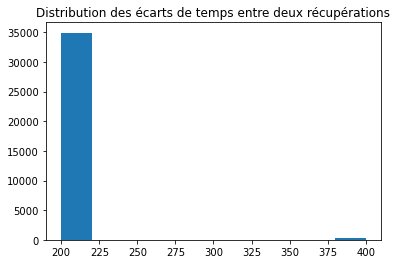

In [10]:
values_time = values_time[counts>1]
counts = counts[counts>1]
plt.title("Distribution des écarts de temps entre deux récupérations")
plt.hist(values_time, weights=counts)

Peut-on en déduire que l'échantillonnage des points est fixe (avec un écart de 200 millisecondes) ?

### Exploration des données

**Quelques statistiques de base sur certaines colonnes ...**

In [11]:
colonnes = ['Time','GpsTime','GpsHeading', 'GpsSpeed','Latitude', 'Longitude', 'Altitude','Pdop']

df[colonnes].describe()

,Time,GpsTime,GpsHeading,GpsSpeed,Latitude,Longitude,Altitude,Pdop
count,3.537200e+04,3.537200e+04,35372.000000,35372.000000,35372.000000,35372.000000,35372.000000,35372.000000
mean,4.781673e+05,4.423678e+08,211.952805,5.031042,42.282868,-83.735335,229.294582,1.914650
std,4.307300e+05,6.020981e+07,93.302970,4.527492,0.001508,0.001193,10.643619,2.568222
min,8.866000e+03,2.221358e+08,0.000200,0.000000,42.279972,-83.738380,207.424000,1.230000
25%,1.670110e+05,4.325398e+08,175.623400,0.150000,42.281387,-83.735771,223.694757,1.530000
50%,3.488350e+05,4.452121e+08,209.716710,4.610000,42.283173,-83.735550,230.304000,1.690000
75%,6.752512e+05,4.844326e+08,268.795043,8.440000,42.283470,-83.734573,236.293000,1.980000
max,1.595894e+06,5.876186e+08,359.996490,17.170000,42.285969,-83.732391,304.120000,99.989998


**Visualisation des colonnes Longitude et Latitude :**

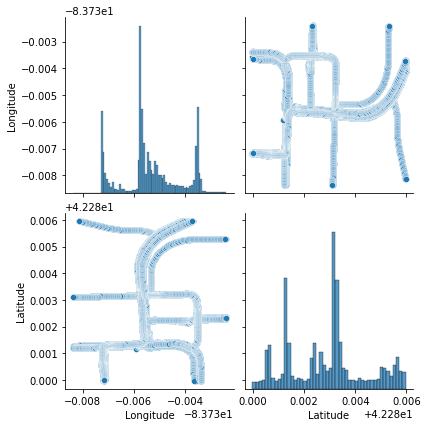

In [12]:
sns.pairplot(df[["Longitude", "Latitude"]], height=3)

**Distribution de la vitesse des GPS :**

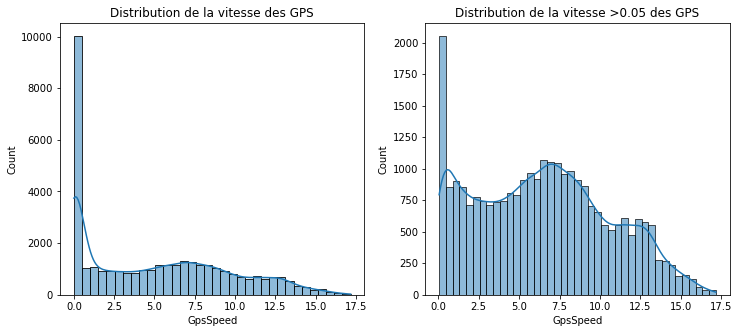

In [13]:
fig, ax =plt.subplots(1,2, figsize=(12,5))
ax[0].set_title('Distribution de la vitesse des GPS')
sns.histplot(df["GpsSpeed"], kde=True, ax=ax[0])
ax[1].set_title('Distribution de la vitesse >0.05 des GPS')
sns.histplot(df.loc[df["GpsSpeed"]>0.05, "GpsSpeed"], kde=True, ax=ax[1])
plt.show()

**Quelques fonctions d'affectation et de visualisations**

In [111]:
#librarie pour dessiner un rectangle
import matplotlib.patches as patches

#Fonction pour affecter des points du dataframe à une case sur un plan
def affectation_2(df, latitude_min, longitude_min, ecart_x, ecart_y):
    """ DataFrame * float * float * flot * float -> Series(int) * Series(int)
        Retourne l'affectation des points du DataFrame en deux Series,
        le premier stock les indices x et le second les indices y.
    """
    x = ((df["Latitude"] - latitude_min)/ecart_x).apply(math.floor)
    y = ((df["Longitude"] - longitude_min)/ecart_y).apply(math.floor)
    
    return x,y

#Permet de sélectionner tous les points appartenant à une case
def trouve_data_case(df, pos, latitude_min, longitude_min, ecart_x, ecart_y):
    """DataFrame * (int,int) * float * float * flot * float -> DataFrame
        Retourne un DataFrame contenant toutes les lignes se situant dans la case pos.
    """
    x, y = affectation_2(df, latitude_min, longitude_min, ecart_x, ecart_y)
    i, j = pos
    return df[(x==i) & (y==j)]

#Dessine un rectangle sur les cases où se trouvent les données sélectionnées
def dessine_rect(df, ax, x_splits, y_splits, latitude_min, longitude_min, ecart_x, ecart_y):
    """ DataFrame * AxesSubplot * float * float * flot * float -> None
        Encadre les cases correspondant aux points du df.
    """
    #calcul des indices x et y des cases pour chaque ligne de df
    x, y = affectation_2(df, latitude_min, longitude_min, ecart_x, ecart_y)
    #pour chaque ligne de df, on encadre en noir sa case
    for i in range(len(x)):
        x_i = x.iloc[i]
        y_i = y.iloc[i]
        ax.add_patch(patches.Rectangle((x_splits[x_i],y_splits[y_i]), ecart_x, ecart_y, edgecolor = 'black', fill=False))

#Ajout du titre et des noms d'axes
def set_ax_legend(ax, title, xlabel, ylabel):
    """ AxesSubplot * str * str * str -> None
        Ajoute le titre et le nom des axes sur ax.
    """
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

#Permet de visualiser le sens de la route
def fleche_sens(df, ax):
    """ DataFrame * AxesSubplot -> None
        Dessine une flèche partant du 1er point et qui est orientée vers le n/2-ème point.
    """
    n = df.shape[0]
    if n > 1:
        x_i = df.iloc[0, tr.columns.get_loc("Latitude")]
        y_i = df.iloc[0, tr.columns.get_loc("Longitude")]
        dx_i = df.iloc[math.floor(n/2), tr.columns.get_loc("Latitude")] - x_i
        dy_i = df.iloc[math.floor(n/2), tr.columns.get_loc("Longitude")] - y_i
        ax.quiver(x_i, y_i, dx_i, dy_i)

**Calcul des paramètres**

In [15]:
#Bornes de la longitude
longitude_min = df["Longitude"].min()
longitude_max = df["Longitude"].max()
#Bornes de la latitude
latitude_min = df["Latitude"].min()
latitude_max = df["Latitude"].max()
#bins / nombre d'intervalles
n_interval = 9
#On sépare en n_interval la latitude et la longitude
x_splits = np.linspace(latitude_min,latitude_max, n_interval)
y_splits = np.linspace(longitude_min,longitude_max, n_interval)
#Ecart entre deux intervalles des axes
ecart_x = x_splits[1]-x_splits[0]
ecart_y = y_splits[1]-y_splits[0]

**Calcul de l'effectif et de la vitesse moyenne de chaque case:**

In [16]:
#Calcul de l'effectif et de la vitesse moyenne sur chaque case
effectif_cases = np.zeros((n_interval,n_interval))
vitesse_cases = np.zeros((n_interval,n_interval))
for i in range(n_interval):
    for j in range(n_interval):
        case_df = trouve_data_case(df, (i, j), latitude_min, longitude_min, ecart_x, ecart_y)
        if case_df.shape[0] > 0 :
            effectif_cases[i,j] = case_df.shape[0]
            vitesse_cases[i,j] = case_df["GpsSpeed"].mean()
            
#Création d'une nouvelles colonnes stockant les données sur les portions de route           
sx,sy = affectation_2(df, latitude_min, longitude_min, ecart_x, ecart_y)
e = [] #liste effectif moyen pour chaque ligne
v = [] #liste vitesse moyenne pour chaque ligne
for i in range(sx.shape[0]) :
    e.append(effectif_cases[sx.iloc[i],sy.iloc[i]])
    v.append(vitesse_cases[sx.iloc[i],sy.iloc[i]])

df["Effectif_case"] = e    
df["Vitesse_moy_case"] = v

**Visualisation graphique de la carte :**

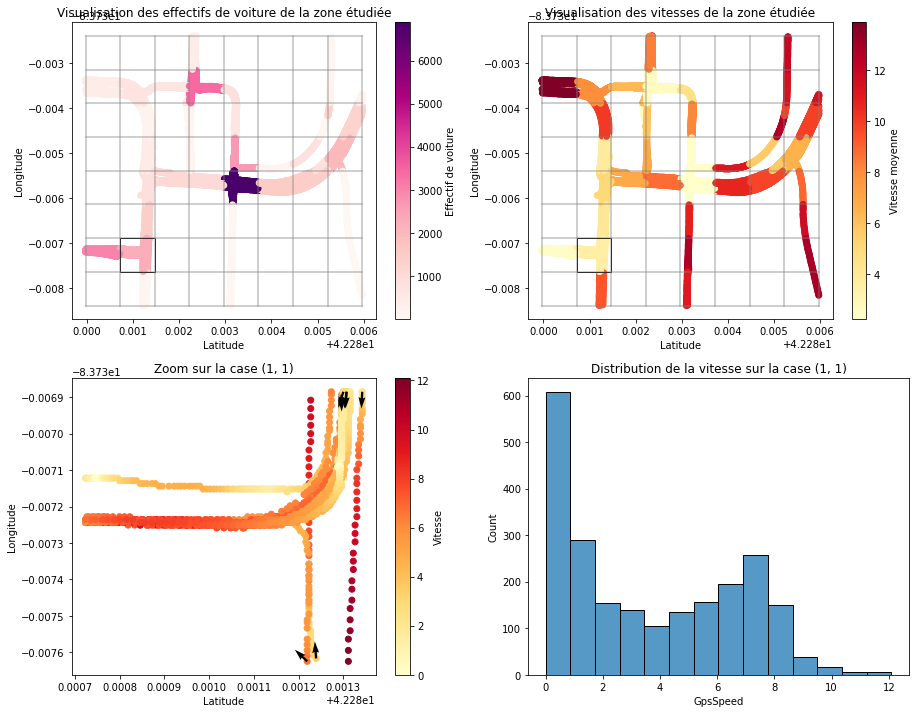

In [126]:
#Tirage aléatoire de lignes du dataframe pour pouvoir se focaliser sur sa case:
#nombre d'exemples à tirer
nb_points = 1
#tirage aléatoire de nb_points lignes
samples = df.sample(nb_points)

fig, ax = plt.subplots(2,2, figsize=(15,12))

#Visualisation (1ème figure):
set_ax_legend(ax[0][0], "Visualisation des effectifs de voiture de la zone étudiée", "Latitude", "Longitude")
p = ax[0][0].scatter(df["Latitude"], df["Longitude"], c=df["Effectif_case"], cmap="RdPu")
cbar = plt.colorbar(p, ax=ax[0][0])
cbar.set_label('Effectif de voiture')

#Visualisation (2ère figure) :
#affichage (latitude,longitude) pour les trips en fonction de la vitesse
set_ax_legend(ax[0][1], 'Visualisation des vitesses de la zone étudiée', "Latitude", "Longitude")
p = ax[0][1].scatter(df["Latitude"], df["Longitude"], c=df["Vitesse_moy_case"], cmap="YlOrRd")
cbar = plt.colorbar(p, ax=ax[0][1])
cbar.set_label('Vitesse moyenne')
    
#affichage grille
for i in range(n_interval):
    x = x_splits[i]
    y = y_splits[i]
    ax[0][0].plot([x,x],[longitude_min, longitude_max], c='grey',  alpha = 0.5)
    ax[0][0].plot([latitude_min,latitude_max],[y,y], c='grey', alpha = 0.5)
    ax[0][1].plot([x,x],[longitude_min, longitude_max], c='grey',  alpha = 0.5)
    ax[0][1].plot([latitude_min,latitude_max],[y,y], c='grey', alpha = 0.5)

#affiche les rectangles correspondant aux données tirées aléatoirement    
dessine_rect(samples, ax[0][0], x_splits, y_splits, latitude_min, longitude_min, ecart_x, ecart_y)
dessine_rect(samples, ax[0][1], x_splits, y_splits, latitude_min, longitude_min, ecart_x, ecart_y)

#si on ne possède qu'une case, alors on fait un zoom dessus
if nb_points == 1:
    
    #Visualisation (3ème figure) :
    sx, sy = affectation_2(samples, latitude_min, longitude_min, ecart_x, ecart_y)
    case_df = trouve_data_case(df, (sx.iloc[0], sy.iloc[0]), latitude_min, longitude_min, ecart_x, ecart_y)
    p = ax[1][0].scatter(case_df["Latitude"], case_df["Longitude"], c=case_df["GpsSpeed"], cmap="YlOrRd")
    cbar = plt.colorbar(p, ax=ax[1][0])
    cbar.set_label('Vitesse')  
    set_ax_legend(ax[1][0], f"Zoom sur la case {(sx.iloc[0],sy.iloc[0])}", "Latitude", "Longitude")
    
    #Affichage du sens de circulation pour la figure 3
    trips_case = np.unique(case_df["Trip"])
    for t in trips_case:
        tr = case_df.loc[case_df["Trip"]==t, ["Latitude","Longitude","GpsHeading"]]
        fleche_sens(tr, ax[1][0])
        
    #Visualisation (4ème figure):
    sns.histplot(case_df["GpsSpeed"],ax=ax[1][1])
    ax[1][1].set_title(f"Distribution de la vitesse sur la case {(sx.iloc[0],sy.iloc[0])}")
          
plt.show()

**Calcul de la norme et de l'angle $\Theta$ des vecteurs vitesse :** 

In [30]:
case_df = trouve_data_case(df, (sx.iloc[0], sy.iloc[0]), latitude_min, longitude_min, ecart_x, ecart_y)
trips_case = np.unique(case_df["Trip"])

liste_norm_v = []
liste_theta_v = []

for t in trips_case:
    tr = case_df.loc[case_df["Trip"]==t, ["GpsTime","Latitude","Longitude"]]                  
    for i in range(1,tr.shape[0]):
        dif_time = (tr["GpsTime"].iloc[i] - tr["GpsTime"].iloc[i-1])
        v = (tr[["Latitude","Longitude"]].iloc[i] - tr[["Latitude","Longitude"]].iloc[i-1])/dif_time
        norm_v = np.sqrt(v["Latitude"]**2 + v["Longitude"]**2)        
        theta = np.arctan(v["Latitude"]/np.maximum(v["Longitude"], 0.0001))
        
        liste_norm_v.append(norm_v)
        liste_theta_v.append(theta)

**Histogramme 3D de la norme des vecteurs de vitesse et ses angles $\Theta$ :**

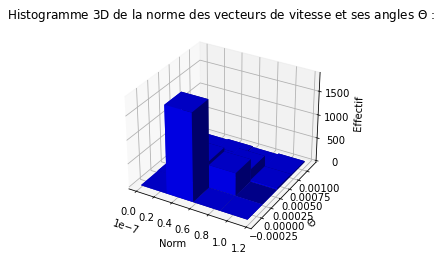

In [127]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

hist, xedges, yedges = np.histogram2d(liste_norm_v, liste_theta_v, bins=4)

# The start of each bucket.
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1])

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)

# The width of each bucket.
dx, dy = np.meshgrid(xedges[1:] - xedges[:-1], yedges[1:] - yedges[:-1])

dx = dx.flatten()
dy = dy.flatten()
dz = hist.flatten()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b', zsort='average')

ax.set_xlabel('Norm')
ax.set_ylabel('$\Theta$')
ax.set_zlabel('Effectif')

plt.title("Histogramme 3D de la norme des vecteurs de vitesse et ses angles $\Theta$ :")

plt.show()

# Modele Physique

### Explication du modele

### Implementation

### Test

In [22]:
# chargement des donnees
tr

,GpsTime,Latitude,Longitude
952570,478559400,42.282227,-83.733566
952571,478559600,42.282238,-83.733566
952572,478559800,42.282246,-83.733566
952573,478560000,42.282257,-83.733566
952574,478560200,42.282265,-83.733566
...,...,...,...
997238,492187800,42.282928,-83.733589
997239,492188000,42.282936,-83.733589
997240,492188200,42.282944,-83.733589
997241,492188400,42.282955,-83.733589


In [23]:
def vald_crois(f,datax, n):
    N = len(datax)
    gap = int(N/n)
    err = []
    for i in range(n):
        X_test = datax[i*gap:(i+1)*gap]
        X_train = np.concatenate((datax[0:i*gap],datax[(i+1)*gap:]), axis = 0), np.concatenate((datay[0:i*gap],datay[(i+1)*gap:]), axis = 0)
        f.fit(X_train)
        err.append(1 - f.score(X_test, Y_test))
    return err

In [24]:
datax = []
tr_arr = tr.to_numpy()
for i in range(len(tr)-2):
    datax.append([tr_arr[i],tr_arr[i+1],tr_arr[i+2]])
    i+=3

datax = np.array(datax)

datax[:,2][:,:2]

array([[4.7855980e+08, 4.2282246e+01],
       [4.7856000e+08, 4.2282257e+01],
       [4.7856020e+08, 4.2282265e+01],
       ...,
       [4.9218820e+08, 4.2282944e+01],
       [4.9218840e+08, 4.2282955e+01],
       [4.9218860e+08, 4.2282963e+01]])

In [25]:
model_phy = mp.modele_physique()

def moindre_c(X_predit, X_test):
    return ((X_predit-X_test)**2).sum()

In [26]:
model_phy.score(moindre_c, datax)

[[[ 4.7855940e+08  4.2282227e+01 -8.3733566e+01]
  [ 4.7855960e+08  4.2282238e+01 -8.3733566e+01]
  [ 4.7855980e+08  4.2282246e+01 -8.3733566e+01]]

 [[ 4.7855960e+08  4.2282238e+01 -8.3733566e+01]
  [ 4.7855980e+08  4.2282246e+01 -8.3733566e+01]
  [ 4.7856000e+08  4.2282257e+01 -8.3733566e+01]]

 [[ 4.7855980e+08  4.2282246e+01 -8.3733566e+01]
  [ 4.7856000e+08  4.2282257e+01 -8.3733566e+01]
  [ 4.7856020e+08  4.2282265e+01 -8.3733566e+01]]

 ...

 [[ 4.9218780e+08  4.2282928e+01 -8.3733589e+01]
  [ 4.9218800e+08  4.2282936e+01 -8.3733589e+01]
  [ 4.9218820e+08  4.2282944e+01 -8.3733589e+01]]

 [[ 4.9218800e+08  4.2282936e+01 -8.3733589e+01]
  [ 4.9218820e+08  4.2282944e+01 -8.3733589e+01]
  [ 4.9218840e+08  4.2282955e+01 -8.3733589e+01]]

 [[ 4.9218820e+08  4.2282944e+01 -8.3733589e+01]
  [ 4.9218840e+08  4.2282955e+01 -8.3733589e+01]
  [ 4.9218860e+08  4.2282963e+01 -8.3733589e+01]]]
[[4.7855980e+08 4.2282246e+01]
 [4.7856000e+08 4.2282257e+01]
 [4.7856020e+08 4.2282265e+01]
 ...
 [

D:\PLDAC\pldac_interpolation-main\models\model_physique.py:15: RuntimeWarning: divide by zero encountered in true_divide
  v_speed = (x_test[0][:2] - x_test[1][:2])/(x_test[1][2] - x_test[0][2])
D:\PLDAC\pldac_interpolation-main\models\model_physique.py:16: RuntimeWarning: invalid value encountered in multiply
  return x_test[1][:2] + v_speed*alpha
D:\PLDAC\pldac_interpolation-main\models\model_physique.py:15: RuntimeWarning: invalid value encountered in true_divide
  v_speed = (x_test[0][:2] - x_test[1][:2])/(x_test[1][2] - x_test[0][2])


nan

<AxesSubplot:xlabel='GpsHeading', ylabel='Count'>

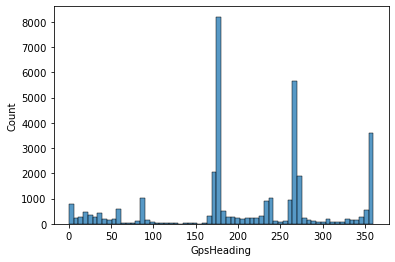

In [44]:
sns.histplot(df["GpsHeading"])